In [ ]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
EPOCHS = 25
INIT_LR = .001
BS = 8
default_image_size = tuple((256, 256))
image_size = 0
directory_root = '/content/drive/MyDrive/Plants/Thesis_dataset'
width=256
height=256
depth=3

In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

                    
            for image in plant_disease_image_list[:85]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True or image_directory.endswith(".png") == True or image_directory.endswith(".jpeg") == True :
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Apple___Apple_scab ...
[INFO] Processing Apple___Black_rot ...
[INFO] Processing Apple___Cedar_apple_rust ...
[INFO] Processing Apple___healthy ...
[INFO] Processing Blueberry___healthy ...
[INFO] Processing Cherry_(including_sour)___Powdery_mildew ...
[INFO] Processing Cherry_(including_sour)___healthy ...
[INFO] Processing Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot ...
[INFO] Processing Corn_(maize)___Common_rust_ ...
[INFO] Processing Corn_(maize)___Northern_Leaf_Blight ...
[INFO] Processing Corn_(maize)___healthy ...
[INFO] Processing Grape___Black_rot ...
[INFO] Processing Grape___Esca_(Black_Measles) ...
[INFO] Processing Grape___Leaf_blight_(Isariopsis_Leaf_Spot) ...
[INFO] Processing Grape___healthy ...
[INFO] Processing Orange___Haunglongbing_(Citrus_greening) ...
[INFO] Processing Peach___Bacterial_spot ...
[INFO] Processing Peach___healthy ...
[INFO] Processing Pepper,_bell___Bacterial_spot ...
[INFO] Processing Pepper,_bel

In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [ ]:
np_image_list = np.array(image_list, dtype=np.float16) / 255.0

In [ ]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.25, random_state = 42) 

[INFO] Spliting data to train, test


In [ ]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [ ]:
import keras
import numpy as np
import cv2
import os
import random
import shutil
import pandas as pd
import csv
import zipfile
from keras import optimizers
from keras.models import Sequential,Model
from keras.layers import Dropout, Flatten, Dense,Input
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint
from keras.applications.imagenet_utils import preprocess_input
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.initializers import RandomNormal
import keras.backend as k
from sklearn.utils import shuffle
import io
from PIL import Image as pil_image


In [ ]:
from keras.applications import resnet
model = resnet.ResNet50

In [ ]:
import tensorflow
resnet = model(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

inp = Input((256,256,3))
x = resnet(inp)
x = tensorflow.keras.layers.GlobalAveragePooling2D()(x)
out = Dense(38, activation='softmax')(x)

model = Model(inp,out)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
#callbacks = myCallback() 
# train the network
print("[INFO] training network...")

[INFO] training network...


In [ ]:
import tensorflow as tf  
checkpoint_filepath='/content/drive/MyDrive/Plants/Thesis_dataset'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=55, verbose=1,
    callbacks=[model_checkpoint_callback]
    )
model.load_weights(checkpoint_filepath)

Epoch 1/55
302/302 [==============================] - 117s 323ms/step - loss: 2.7705 - accuracy: 0.2763 - val_loss: 50.5593 - val_accuracy: 0.0272
Epoch 2/55
302/302 [==============================] - 91s 300ms/step - loss: 1.4689 - accuracy: 0.5601 - val_loss: 15.0426 - val_accuracy: 0.0322
Epoch 3/55
302/302 [==============================] - 91s 300ms/step - loss: 0.9950 - accuracy: 0.6901 - val_loss: 5.8113 - val_accuracy: 0.1002
Epoch 4/55
302/302 [==============================] - 92s 305ms/step - loss: 0.7360 - accuracy: 0.7589 - val_loss: 2.0101 - val_accuracy: 0.5186
Epoch 5/55
302/302 [==============================] - 90s 298ms/step - loss: 0.5756 - accuracy: 0.8152 - val_loss: 2.2559 - val_accuracy: 0.5186
Epoch 6/55
302/302 [==============================] - 89s 293ms/step - loss: 0.5021 - accuracy: 0.8451 - val_loss: 4.7757 - val_accuracy: 0.3193
Epoch 7/55
302/302 [==============================] - 91s 301ms/step - loss: 0.4269 - accuracy: 0.8687 - val_loss: 1.1938 - val

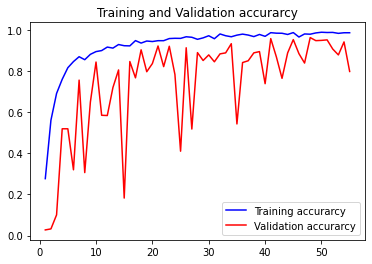

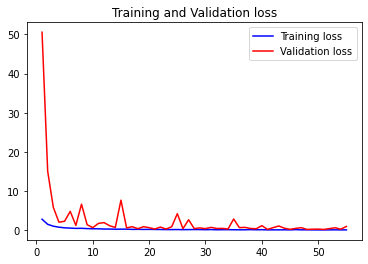

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
testpred = model.predict(x_test)

In [ ]:
LABELS = ['Apple___Apple_scab' ,'Apple___Black_rot' ,'Apple___Cedar_apple_rust',
 'Apple___healthy', 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_' ,'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy' ,'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)' ,'Peach___Bacterial_spot',
 'Peach___healthy' ,'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy' ,'Potato___Early_blight' ,'Potato___Late_blight',
 'Potato___healthy' ,'Raspberry___healthy', 'Soybean___healthy',
 'Squash___Powdery_mildew' ,'Strawberry___Leaf_scorch',
 'Strawberry___healthy' ,'Tomato___Bacterial_spot', 'Tomato___Early_blight',
 'Tomato___Late_blight' ,'Tomato___Leaf_Mold' ,'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

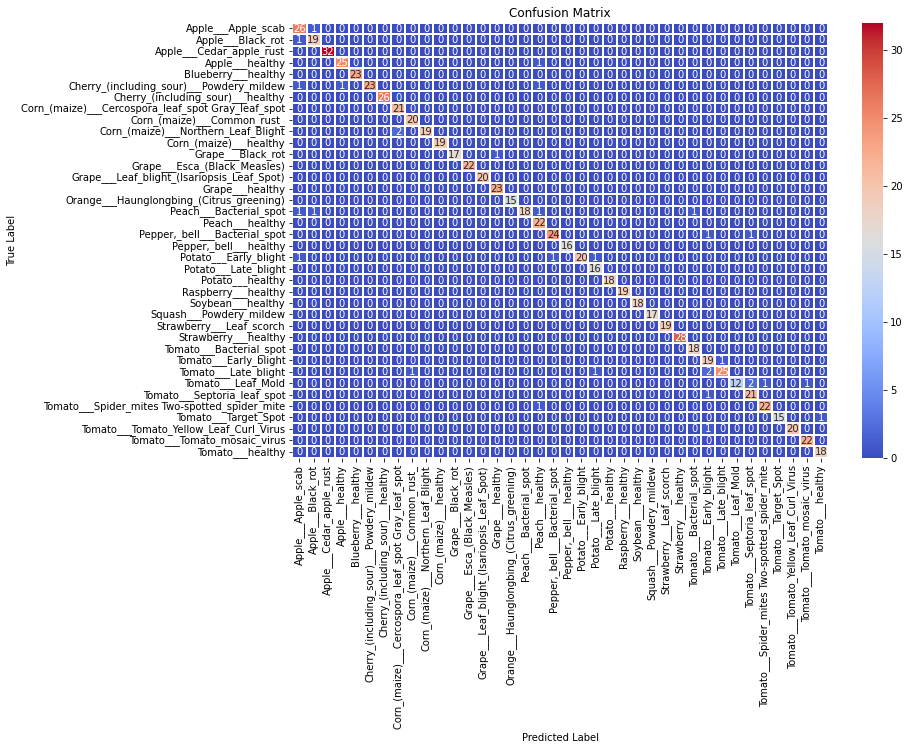

              precision    recall  f1-score   support

           0       0.87      0.96      0.91        27
           1       0.90      0.95      0.93        20
           2       1.00      1.00      1.00        32
           3       0.96      0.96      0.96        26
           4       1.00      1.00      1.00        23
           5       1.00      0.88      0.94        26
           6       1.00      1.00      1.00        26
           7       0.91      1.00      0.95        21
           8       0.95      1.00      0.98        20
           9       1.00      0.90      0.95        21
          10       1.00      1.00      1.00        19
          11       1.00      0.94      0.97        18
          12       1.00      1.00      1.00        22
          13       1.00      1.00      1.00        20
          14       0.96      1.00      0.98        23
          15       1.00      1.00      1.00        15
          16       1.00      0.82      0.90        22
          17       0.85    

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import roc_curve, auc, roc_auc_score


def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(12, 8))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


rounded_predictions = np.argmax(testpred, axis=1)
rounded_labels=np.argmax(y_test, axis=1)
show_confusion_matrix(rounded_labels, rounded_predictions)
print(classification_report(rounded_labels, rounded_predictions))

In [ ]:
ypred = testpred.argmax(axis=-1)
ytest = y_test.argmax(axis=-1)

ROC AUC score: 0.9808253287059144


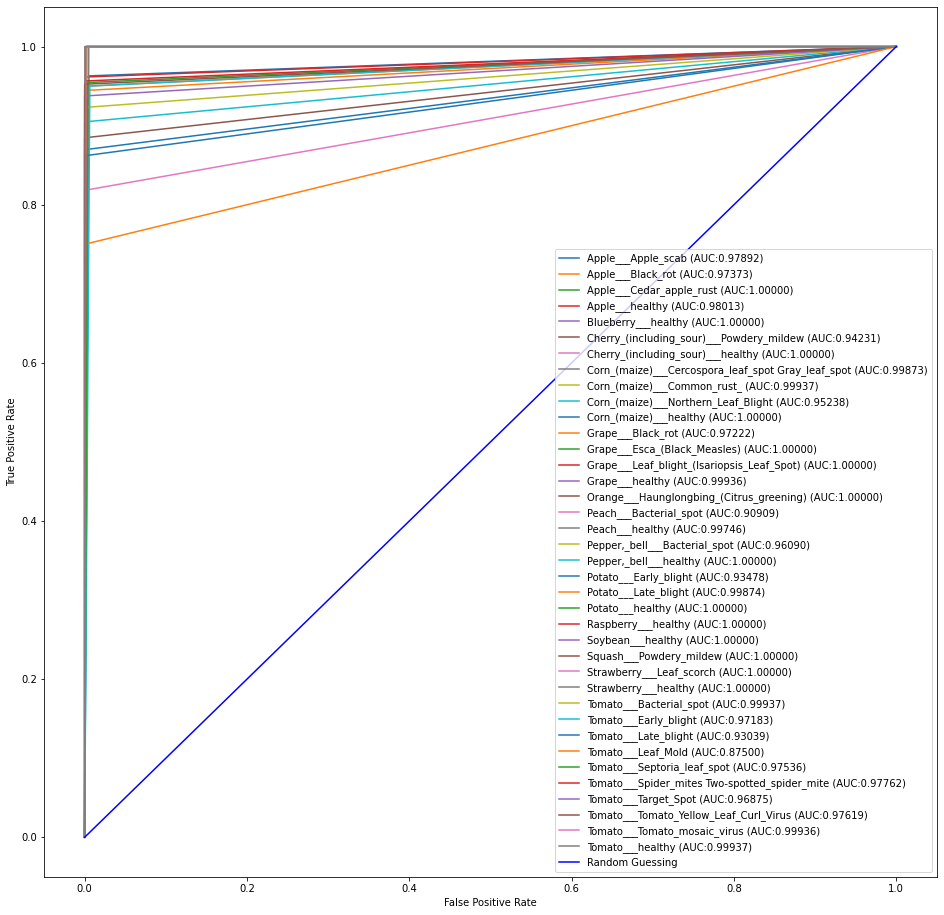

In [ ]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


target= ['Apple___Apple_scab' ,'Apple___Black_rot' ,'Apple___Cedar_apple_rust',
 'Apple___healthy', 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_' ,'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy' ,'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)' ,'Peach___Bacterial_spot',
 'Peach___healthy' ,'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy' ,'Potato___Early_blight' ,'Potato___Late_blight',
 'Potato___healthy' ,'Raspberry___healthy', 'Soybean___healthy',
 'Squash___Powdery_mildew' ,'Strawberry___Leaf_scorch',
 'Strawberry___healthy' ,'Tomato___Bacterial_spot', 'Tomato___Early_blight',
 'Tomato___Late_blight' ,'Tomato___Leaf_Mold' ,'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (16, 16))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.5f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(ytest, ypred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()